In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
from dateutil import parser
import datetime as dt
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [3]:
df_raw = pd.read_pickle("../data/EUR_USD_H1.pkl")

In [4]:
df_an = df_raw.copy()
df_an.reset_index(drop=True, inplace=True)

In [5]:
df_an = RSI(df_an)
df_an.tail()

,time,volume,bid_o,bid_h,bid_l,bid_c,mid_o,mid_h,mid_l,mid_c,ask_o,ask_h,ask_l,ask_c,RSI_14
37214,2021-12-30 19:00:00+00:00,1063,1.13052,1.13291,1.13036,1.13267,1.13058,1.13298,1.13043,1.13274,1.13065,1.13306,1.13049,1.13280,51.407635
37215,2021-12-30 20:00:00+00:00,1092,1.13264,1.13297,1.13177,1.13186,1.13272,1.13304,1.13185,1.13193,1.13279,1.13311,1.13192,1.13200,48.671929
37216,2021-12-30 21:00:00+00:00,388,1.13188,1.13269,1.13187,1.13249,1.13195,1.13276,1.13194,1.13258,1.13202,1.13283,1.13201,1.13267,50.928675
37217,2021-12-30 22:00:00+00:00,118,1.13204,1.13236,1.13182,1.13218,1.13252,1.13264,1.13222,1.13230,1.13299,1.13299,1.13236,1.13243,49.910668
37218,2021-12-30 23:00:00+00:00,507,1.13214,1.13251,1.13183,1.13216,1.13227,1.13258,1.13190,1.13224,1.13240,1.13266,1.13198,1.13231,49.681497


In [6]:
df_an = apply_patterns(df_an)

In [7]:
df_an['EMA_200'] = df_an.mid_c.ewm(span=200, min_periods=200).mean()

In [8]:
df_an.columns

Index(['time', 'volume', 'bid_o', 'bid_h', 'bid_l', 'bid_c', 'mid_o', 'mid_h',
       'mid_l', 'mid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'RSI_14',
       'body_lower', 'body_upper', 'body_bottom_perc', 'body_top_perc',
       'body_perc', 'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'EMA_200'],
      dtype='object')

In [9]:
our_cols = ['time', 'mid_o','mid_h','mid_l', 'mid_c',
             'ask_o', 'ask_h', 'ask_l', 'ask_c',
             'bid_o', 'bid_h', 'bid_l', 'bid_c',
            'ENGULFING', 'direction','EMA_200', 'RSI_14']

In [10]:
df_slim = df_an[our_cols].copy()
df_slim.dropna(inplace = True)
df_slim.reset_index(drop=True, inplace=True)

In [11]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_o,ask_h,ask_l,ask_c,bid_o,bid_h,bid_l,bid_c,ENGULFING,direction,EMA_200,RSI_14
0,2016-01-19 07:00:00+00:00,1.08736,1.08764,1.08595,1.08652,1.08745,1.08772,1.08603,1.08660,1.08726,1.08756,1.08587,1.08645,False,-1,1.088334,36.239350
1,2016-01-19 08:00:00+00:00,1.08654,1.08846,1.08636,1.08846,1.08662,1.08861,1.08644,1.08861,1.08647,1.08832,1.08629,1.08832,True,1,1.088336,47.615598
2,2016-01-19 09:00:00+00:00,1.08844,1.08890,1.08702,1.08724,1.08854,1.08898,1.08710,1.08749,1.08834,1.08883,1.08694,1.08699,False,-1,1.088323,42.482293
3,2016-01-19 10:00:00+00:00,1.08728,1.08834,1.08662,1.08730,1.08755,1.08842,1.08668,1.08737,1.08702,1.08827,1.08655,1.08722,False,1,1.088312,42.808846
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08734,1.08738,1.08605,1.08637,1.08721,1.08726,1.08593,1.08623,True,-1,1.088289,38.849941


In [12]:
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0

def apply_signal(row):
    if row.ENGULFING == True:
        if row.direction == BUY and row.mid_l > row.EMA_200:
            if row.RSI_14 > RSI_LIMIT:
                return BUY
        if row.direction == SELL and row.mid_h < row.EMA_200:
            if row.RSI_14 < RSI_LIMIT:
                return SELL
    return NONE

In [13]:
df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)

In [14]:
df_slim["SIGNAL"].value_counts()

SIGNAL
 0    33779
-1     1635
 1     1606
Name: count, dtype: int64

In [16]:
LOSS_FACTOR = -1.0
PROFIT_FACTOR = 1.5

def apply_take_profit(row): #when the signal is buy - gives the TAKE PROFIT price
    if row.SIGNAL != NONE:
        if row.SIGNAL == BUY:
            return (row.ask_c -row.ask_o) * PROFIT_FACTOR + row.ask_c
        else: #SIGNAL == SELL
            return (row.bid_c -row.bid_o) * PROFIT_FACTOR + row.bid_c
    else:
        return 0.0

def apply_stop_loss(row):#when the signal is sell - gives the STOP LOSS price
    if row.SIGNAL != NONE:
        if row.SIGNAL == BUY:
            return row.ask_o
        else:
            return row.bid_o
    else:
        return 0.0

In [17]:
df_slim["TP"] = df_slim.apply(apply_take_profit, axis=1)
df_slim["SL"] = df_slim.apply(apply_stop_loss, axis=1)

In [21]:
df_slim[df_slim.SIGNAL == SELL].head()

,time,mid_o,mid_h,mid_l,mid_c,ask_o,ask_h,ask_l,ask_c,bid_o,bid_h,bid_l,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08734,1.08738,1.08605,1.08637,1.08721,1.08726,1.08593,1.08623,True,-1,1.088289,38.849941,-1,1.084760,1.08721
62,2016-01-21 21:00:00+00:00,1.08878,1.08891,1.08746,1.08751,1.08887,1.08901,1.08756,1.08768,1.08870,1.08881,1.08733,1.08734,True,-1,1.088921,49.285917,-1,1.085300,1.08870
69,2016-01-22 04:00:00+00:00,1.08407,1.08411,1.08325,1.08342,1.08415,1.08418,1.08333,1.08349,1.08399,1.08404,1.08317,1.08336,True,-1,1.088635,39.611746,-1,1.082415,1.08399
76,2016-01-22 11:00:00+00:00,1.08434,1.08434,1.08245,1.08314,1.08442,1.08442,1.08251,1.08321,1.08427,1.08427,1.08238,1.08307,True,-1,1.088268,40.878316,-1,1.081270,1.08427
81,2016-01-22 16:00:00+00:00,1.08242,1.08329,1.08059,1.08134,1.08248,1.08335,1.08066,1.08141,1.08237,1.08323,1.08051,1.08127,True,-1,1.087931,37.215991,-1,1.079620,1.08237


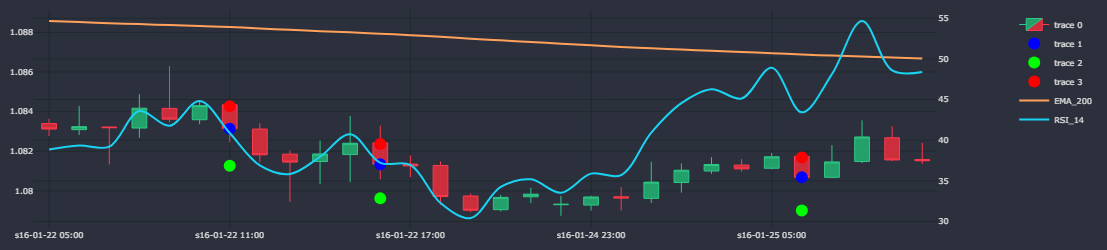

In [23]:
df_plot = df_slim.iloc[70:100]
cp = CandlePlot(df_plot, candles=True)

trades = cp.df_plot[df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[markers[i]],
        mode = 'markers',
        marker = dict(color=marker_colors[i], size=12)
    ))
cp.show_plot(line_traces = ["EMA_200"], sec_traces = ['RSI_14'], height =250)

In [ ]:
df_results.head()

In [24]:
class Trade:
    def __init__(self, row):
        self.running = True
        self.start_index = row.name
        
        if row.SIGNAL == BUY:
            self.start_price = row.ask_c
            self.trigger_price = row.ask_c
        else:
            self.start_price = row.bid_c
            self.trigger_price = row.bid_c
            
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.bid_h >= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.bid_h)
            elif row.bid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.bid_l)
        if self.SIGNAL == SELL:
            if row.ask_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.ask_l)
            elif row.ask_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.ask_h)
            

In [25]:
open_trades = []
closed_trades = [] 

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row)
        if ot.running == False:
            closed_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True ]

    if row.SIGNAL != NONE:
        open_trades.append(Trade(row))

In [26]:
df_results = pd.DataFrame.from_dict([vars(x) for x in closed_trades])

In [28]:
df_results.result.sum()

-396.0

In [29]:
df_results.sort_values(by = "start_index", inplace=True)

In [30]:
df_m5 = pd.read_pickle("../data/EUR_USD_M5.pkl") # 5mintuets Candle

In [31]:
df_m5.shape

(445038, 14)

In [34]:
df_m5_slim = df_m5[['time', 'bid_h', 'bid_l', 'ask_h', 'ask_l']].copy()

In [36]:
df_m5_slim.head()

,time,bid_h,bid_l,ask_h,ask_l
0,2016-01-07 00:00:00+00:00,1.07802,1.07750,1.07820,1.07768
1,2016-01-07 00:05:00+00:00,1.07811,1.07755,1.07827,1.07772
2,2016-01-07 00:10:00+00:00,1.07823,1.07803,1.07840,1.07822
3,2016-01-07 00:15:00+00:00,1.07821,1.07790,1.07838,1.07807
4,2016-01-07 00:20:00+00:00,1.07789,1.07768,1.07809,1.07784


In [47]:
df_signals = df_slim[df_slim.SIGNAL != NONE].copy()

In [48]:
df_signals['m5_start'] = df_signals.time + dt.timedelta(hours = 1)

In [49]:
df_signals['start_index_h1'] = df_signals.index

In [50]:
df_signals.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_o,ask_h,ask_l,ask_c,bid_o,...,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL,m5_start,start_index_h1
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08734,1.08738,1.08605,1.08637,1.08721,...,1.08623,True,-1,1.088289,38.849941,-1,1.084760,1.08721,2016-01-19 12:00:00+00:00,4
15,2016-01-19 22:00:00+00:00,1.09060,1.09143,1.09052,1.09140,1.09110,1.09156,1.09063,1.09153,1.09010,...,1.09127,True,1,1.088541,57.545307,1,1.092175,1.09110,2016-01-19 23:00:00+00:00,15
17,2016-01-20 00:00:00+00:00,1.09112,1.09246,1.09100,1.09214,1.09120,1.09255,1.09108,1.09223,1.09104,...,1.09206,True,1,1.088610,59.970073,1,1.093775,1.09120,2016-01-20 01:00:00+00:00,17
23,2016-01-20 06:00:00+00:00,1.09491,1.09635,1.09491,1.09546,1.09498,1.09643,1.09498,1.09554,1.09484,...,1.09538,True,1,1.088985,68.866726,1,1.096380,1.09498,2016-01-20 07:00:00+00:00,23
25,2016-01-20 08:00:00+00:00,1.09398,1.09760,1.09397,1.09625,1.09405,1.09768,1.09403,1.09631,1.09390,...,1.09619,True,1,1.089121,67.087323,1,1.099700,1.09405,2016-01-20 09:00:00+00:00,25


In [55]:
df_signals.head()

,start_price_SELL,start_price_BUY,SIGNAL,TP,SL,time,start_index_h1
4,1.08637,1.08623,-1,1.084760,1.08721,2016-01-19 12:00:00+00:00,4
15,1.09153,1.09127,1,1.092175,1.09110,2016-01-19 23:00:00+00:00,15
17,1.09223,1.09206,1,1.093775,1.09120,2016-01-20 01:00:00+00:00,17
23,1.09554,1.09538,1,1.096380,1.09498,2016-01-20 07:00:00+00:00,23
25,1.09631,1.09619,1,1.099700,1.09405,2016-01-20 09:00:00+00:00,25


In [52]:
df_signals.drop(['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'ask_o', 'ask_h', 'ask_l',
        'bid_o', 'bid_h', 'bid_l', 'ENGULFING', 'direction',
       'EMA_200', 'RSI_14'], axis = 1, inplace = True)

In [54]:
df_signals.rename(columns={ 
    'bid_c' : 'start_price_BUY',
    'ask_c' : 'start_price_SELL',
    'm5_start' : 'time'
}, inplace = True)

In [56]:
merged = pd.merge(left = df_m5_slim, right = df_signals, on = 'time', how = 'left')

In [58]:
merged[merged.SIGNAL.isna() == False].head()
merged.fillna(0, inplace=True)
merged.SIGNAL = merged.SIGNAL.astype(int)
merged.start_index_h1 = merged.start_index_h1.astype(int)

In [59]:
merged.head()

,time,bid_h,bid_l,ask_h,ask_l,start_price_SELL,start_price_BUY,SIGNAL,TP,SL,start_index_h1
0,2016-01-07 00:00:00+00:00,1.07802,1.07750,1.07820,1.07768,0.0,0.0,0,0.0,0.0,0
1,2016-01-07 00:05:00+00:00,1.07811,1.07755,1.07827,1.07772,0.0,0.0,0,0.0,0.0,0
2,2016-01-07 00:10:00+00:00,1.07823,1.07803,1.07840,1.07822,0.0,0.0,0,0.0,0.0,0
3,2016-01-07 00:15:00+00:00,1.07821,1.07790,1.07838,1.07807,0.0,0.0,0,0.0,0.0,0
4,2016-01-07 00:20:00+00:00,1.07789,1.07768,1.07809,1.07784,0.0,0.0,0,0.0,0.0,0


In [61]:
class TradeM5:
    def __init__(self, row):
        self.running = True
        self.start_index_m5 = row.name
        self.start_index_h1 = row.start_index_h1
        
        if row.SIGNAL == BUY:
            self.start_price = row.start_price_BUY
            self.trigger_price = row.start_price_BUY
        else:
            self.start_price = row.start_price_SELL
            self.trigger_price = row.start_price_SELL
            
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    def update(self, row):   
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.bid_h >= self.TP:   
                self.close_trade(row, PROFIT_FACTOR, row.bid_h)
            elif row.bid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.bid_l)
        if self.SIGNAL == SELL:
            if row.ask_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.ask_l)
            elif row.ask_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.ask_h)
            

In [62]:
open_trades_m5 = []
closed_trades_m5= [] 

for index, row in merged.iterrows():
    
    for ot in open_trades_m5:
        ot.update(row)
        if ot.running == False:
            closed_trades_m5.append(ot)
    open_trades_m5 = [x for x in open_trades_m5 if x.running == True ]

    if row.SIGNAL != NONE:
        open_trades_m5.append(TradeM5(row))

In [63]:
df_res_m5 = pd.DataFrame.from_dict([vars(x) for x in closed_trades_m5])

In [64]:
df_res_m5.head()

,running,start_index_m5,start_index_h1,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
0,False,2445,4,1.08637,1.08746,-1,1.084760,1.08721,-1.0,2016-01-19 12:05:00+00:00,2016-01-19 12:00:00+00:00,1
1,False,2577,15,1.09127,1.09097,1,1.092175,1.09110,-1.0,2016-01-19 23:05:00+00:00,2016-01-19 23:00:00+00:00,1
2,False,2601,17,1.09206,1.09404,1,1.093775,1.09120,1.5,2016-01-20 03:00:00+00:00,2016-01-20 01:00:00+00:00,24
3,False,2673,23,1.09538,1.09488,1,1.096380,1.09498,-1.0,2016-01-20 07:20:00+00:00,2016-01-20 07:00:00+00:00,4
4,False,2697,25,1.09619,1.09362,1,1.099700,1.09405,-1.0,2016-01-20 09:20:00+00:00,2016-01-20 09:00:00+00:00,4


In [65]:
df_res_m5.result.sum()

-797.5

In [ ]:
merged[merged.SIGNAL!=0]